In [1]:
# Libraries used
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
import lightgbm as lgb

train_df = pd.read_csv("/home/druglord/Documents/ML/Competetion/house-prices-advanced-regression-techniques/train.csv")
test_df = pd.read_csv("/home/druglord/Documents/ML/Competetion/house-prices-advanced-regression-techniques/test.csv")
# train_df

In [ ]:
# Steps to follow
# 1. Remove outliers
#       1.1. Using Query
#       1.2. Use mean/median points
#       1.3. Use pyplots to look for outliers
#       1.4. Use zscore for outliers(4+ are outliers)
#       1.5. Handling missing values
#       1.6. Remove outliers
# 2. Handling missing values
# 3. Use median to replace value instead of mean
# 4. Remove Z score greater than 4, 5, 7, 8
# 5. Feature Engineering
#       5.1. One hot encoding
#       5.2. Binning => Group continuous data into bins
#       5.3. Polynomial Features
#       5.4. Feature Scaling
#       5.5. Log Transform
#       5.6. Target Encoding
#       5.7. Frequency encoding
#       5.8. Data bucketizing
#       5.9. Normalize
#       5.10. Feature Crossing
#       5.11. Principal Component Analysis
# 6. Neural Network gives better results?

In [ ]:
# Removing outliers
# 1.1 Using Query
outliers_q = train_df.query("SalePrice > 600000" and "LotArea > 60000")


# 1.2 Using mean/median value point
#       1.2.1 Normal Distribution
# Below => mean - 3 * (sigma)
# Above => mean + 3 * (sigma)
#       1.2.3 Skewed Distribution
# Below => q1 - 1.5 * iqr
# Above => q3 + 1.5 * iqr
arg = "SalePrice"
q1 = train_df[arg].quantile(0)
q3 = train_df[arg].quantile(.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr
# Mean/median outlier 
outliers_m = train_df[(train_df[arg] < low) | (train_df[arg] > up)]


# 1.3 Using scatter plots
# plt.scatter(x = "SalePrice", y = "YrSold", data = train_df)

# 1.4. Using zscore
outliers_z_t = stats.zscore(train_df["SalePrice"]).sort_values().head(10)
outliers_z = train_df.loc[train_df['Id'].isin(outliers_z_t.index.tolist())]

# 1.5 Remove the outliers
ids = [54, 198, 225, 232, 250, 279, 314, 336, 385, 441, 452, 458, 478, 497, 524, 662, 679, 692, 707, 770, 804, 849, 899, 935, 1025, 1047, 1128, 1170, 1183, 1299, 1374, 1397]
# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]
train_df_filtered = train_df[~train_df['Id'].isin(new_df['Id'])]
train_df_filtered
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(10))

# train_df = train_df[train_df.Id.isin(outliers_q.index.tolist()) == False]


In [2]:
def analyze_outliers(arg1, arg2, quan_1, quan_3, arg1_val, arg2_val, arg1_val_max=None, arg2_val_max=None):
    # Define your conditions
    if arg1_val_max is None and arg2_val_max is None:
        condition = f"{arg1} > {arg1_val} or {arg2} > {arg2_val}"
    elif arg1_val_max is None:
        condition = f"{arg1} > {arg1_val} or {arg2}.between({arg2_val}, {arg2_val_max})"
    elif arg2_val_max is None:
        condition = f"{arg1} > {arg1_val} and {arg1} < {arg1_val_max} or {arg2} > {arg2_val}"
    else:
        condition = f"{arg1} > {arg1_val}  and {arg1} < {arg1_val_max} or {arg2}.between({arg2_val}, {arg2_val_max})"       
    
    flag = False

    outliers_q = train_df.query(condition)
    
    q1 = train_df[arg2].quantile(quan_1)
    q3 = train_df[arg2].quantile(quan_3)
    iqr = q3 - q1
    up = q3 + 1.5 * iqr
    low = q1 - 1.5 * iqr
    
    # Mean/median outlier
    outliers_m = train_df[(train_df[arg2] < low) | (train_df[arg2] > up)]
    
    # Zscore
    outliers_z_t = stats.zscore(train_df[arg2]).sort_values().tail(10)
    outliers_z = train_df.loc[train_df['Id'].isin(outliers_z_t.index.tolist())]
    if flag == True:
    # Query
        print("Outliers using query for", arg2, len(outliers_q))
    # print(outliers_q["Id"].tolist())
        print(', '.join(map(str, outliers_q["Id"].tolist())))
    
    # Mean
        print("Outliers using mean/median", arg2, len(outliers_m["Id"].tolist()))
        print(', '.join(map(str, outliers_m["Id"].tolist())))
    
    # Train Raw
        print("Sale price zscore with train_df raw", arg2, len(outliers_z_t.index.tolist()))
        print(outliers_z_t)
    # print(outliers_z_t.index.tolist())

        print(', '.join(map(str, [index + 1 for index in outliers_z_t.index.tolist()])))    
    
    # Scatter plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plots
    sns.scatterplot(x=arg1, y=arg2, data=train_df, label="train", ax=axes[0])
    sns.scatterplot(x=arg1, y=arg2, data=outliers_q, label="q", ax=axes[0])
    sns.scatterplot(x=arg1, y=arg2, data=outliers_m, label="m", ax=axes[0])
    sns.scatterplot(x=arg1, y=arg2, data=outliers_z, label="z", ax=axes[0])
    
    # KDE plots
    sns.kdeplot(x=arg1, y=arg2, data=train_df, ax=axes[1], label="train")
    sns.kdeplot(x=arg1, y=arg2, data=outliers_q, ax=axes[1], label="outliers_q", warn_singular=False)
    sns.kdeplot(x=arg1, y=arg2, data=outliers_m, ax=axes[1], label="outliers_m", warn_singular=False)
    sns.kdeplot(x=arg1, y=arg2, data=outliers_z, ax=axes[1], label="outliers_z")
    
    # Set titles for subplots
    axes[0].set_title(f"Scatter Plot of {arg2} vs. SalePrice")
    axes[1].set_title(f"KDE Plot of {arg2} vs. SalePrice")
    
    # Show plots
    plt.show()

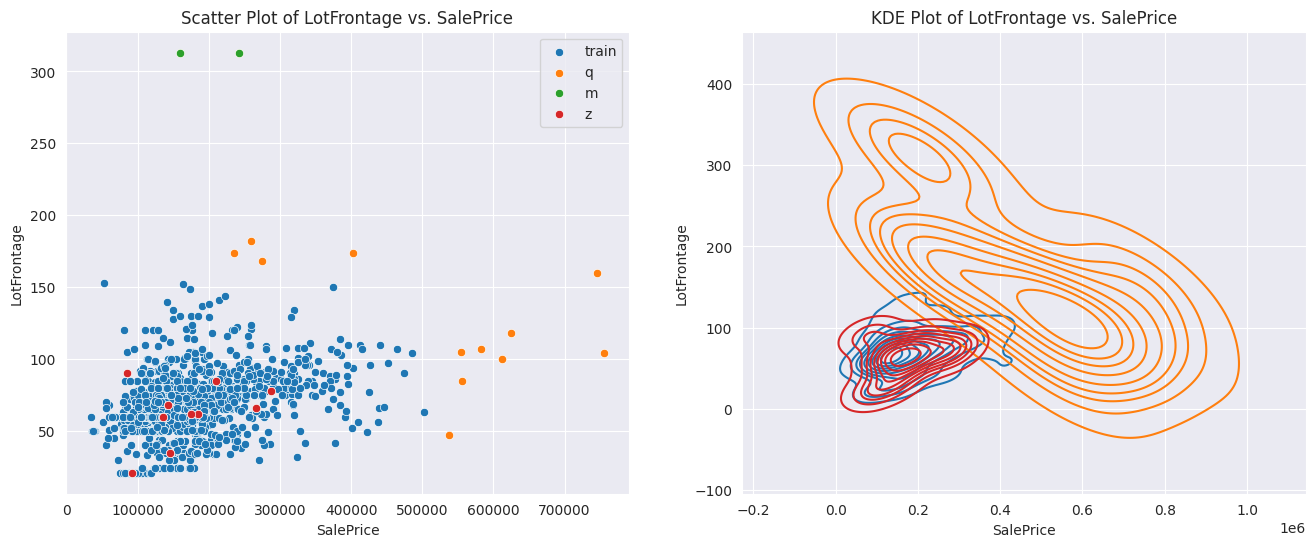

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
# Call the function with the desired arguments

analyze_outliers(arg1="SalePrice", arg2="LotFrontage", arg1_val=520000, arg2_val=160, arg1_val_max=None, arg2_val_max = None, quan_1=0.21, quan_3=0.95)
# print(train_df.dtypes[train_df.dtypes != 'object'].iloc[19:39])
train_df.describe()

# numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
# for column in numeric_columns:
#     analyze_outliers(arg1="SalePrice", arg2=column, arg1_val=700000, arg2_val=(train_df[column].max())*.8, quan_1=0.21, quan_3 = 0.95)


<Axes: xlabel='SalePrice', ylabel='LotArea'>

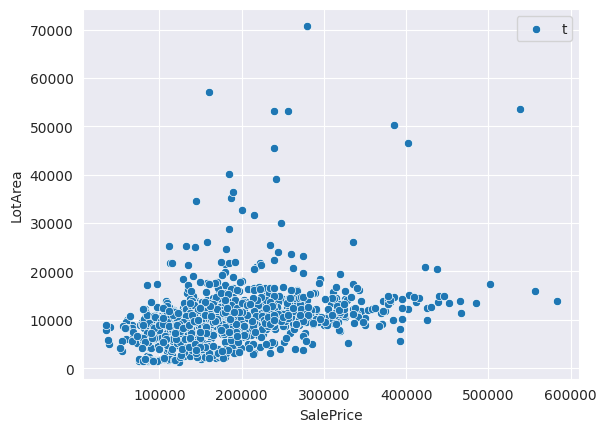

In [4]:
# Remove the outliers
ids = [692, 1170, 1183, 692, 1183, 935, 1299, 692, 1183, 707, 250, 336, 314, 692, 1183, 379, 692, 1183, 692, 1183, 186, 298, 692, 1170, 692, 1183, 692, 899, 1170, 1183, 1299, 441, 314, 692, 1183, 692, 899, 1170, 1183, 225, 692, 1183, 1299, 739, 692, 1183, 692, 1183, 598, 955, 692, 1183, 692, 1183, 636, 692, 1183, 955, 49, 810, 692, 1183, 636, 692, 1183, 582, 1062, 1191, 1299, 692, 899, 1170, 1183, 347, 1231]

counts = Counter(ids)
ll = []

for key, value in counts.items():
    # if value >= 2:
    ll.append(key)    

# for value in ll:
#     print(value , ids.count(value))

# Remove Id from train_df that are in new_df
new_df = train_df.loc[train_df['Id'].isin(ll)]
train_dff = train_df[~train_df['Id'].isin(new_df['Id'])]

sns.scatterplot(x="SalePrice", y="LotArea", data=train_dff, label="t")
# sns.scatterplot(x="SalePrice", y="LotArea", data=new_df, label="m")


In [118]:
# 2. Handling missing values
# View the missing values
# Checking from this list we can fill values with our desired values
# print(train_df.dtypes[train_df.dtypes != 'object']
# print(pd.DataFrame(train_dff.isnull().sum().sort_values(ascending=False)).head(20))


# Only printing object type data  for convenience
# print(pd.DataFrame(train_dff.isnull().sum().sort_values(ascending=False)).head(20))
# print(pd.DataFrame(train_dff.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)).head(10))
# print(pd.DataFrame(train_dff.select_dtypes(include=['int', 'float']).isnull().sum().sort_values(ascending=False)).head(10))

# View how many data is not object type
# print(train_df.dtypes[train_dff.dtypes != 'object'].count())  

# Count how many has that data
# print(train_dff.query('Alley =="Pave"').count())
# print(train_dff.query('Alley =="Grvl"').count())

# Check the value of that data that it contains
# print(train_dff["Electrical"].unique())
# Now we can fill the values with our desired values

# After looking at the catplot, we can decide which value to fill with
# train_dff["Electrical"] = train_dff["Electrical"].fillna("SBrkr")
# test_df["Electrical"] = test_df["Electrical"].fillna("SBrkr")

# train_dff["LotFrontage"].fillna(0, inplace = True)
# test_df["LotFrontage"].fillna(0, inplace = True)
# sns.catplot(x= "Electrical", y = "SalePrice", data=train_dff, kind="box")


# Check co-relation to get co-relation
# train_dff["GarageYrBlt"].corr(train_dff["YearBuilt"])
# 2.3 Drop the features with most of the missing values
# train_dff = train_dff.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "GarageYrBlt","GarageCond", "BsmtFinType2" ])
# test_dff = test_df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "GarageYrBlt","GarageCond", "BsmtFinType2" ])

              0
Id            0
FireplaceQu   0
Functional    0
TotRmsAbvGrd  0
KitchenQual   0
KitchenAbvGr  0
BedroomAbvGr  0
HalfBath      0
FullBath      0
BsmtHalfBath  0
BsmtFullBath  0
GrLivArea     0
LowQualFinSF  0
2ndFlrSF      0
1stFlrSF      0
Electrical    0
CentralAir    0
Fireplaces    0
GarageType    0
MSSubClass    0


In [167]:
# Feature Engineering
train_dff["houseage"] = train_dff["YrSold"] - train_dff["YearBuilt"]
test_df["houseage"] = test_df["YrSold"] - test_df["YearBuilt"]
train_dff["houseremodelage"] = train_dff["YrSold"] - train_dff["YearRemodAdd"]
test_df["houseremodelage"] = test_df["YrSold"] - test_df["YearRemodAdd"]
train_dff["totalsf"] = train_dff["1stFlrSF"] + train_dff["2ndFlrSF"] + train_dff["BsmtFinSF1"] + train_dff["BsmtFinSF2"]
test_df["totalsf"] = test_df["1stFlrSF"] + test_df["2ndFlrSF"] + test_df["BsmtFinSF1"] + test_df["BsmtFinSF2"]
train_dff["totalarea"] = train_dff["GrLivArea"] + train_dff["TotalBsmtSF"]
test_df["totalarea"] = test_df["GrLivArea"] + test_df["TotalBsmtSF"]
train_dff["totalbaths"] = train_dff["BsmtFullBath"] + train_dff["FullBath"] + 0.5 * train_dff["HalfBath"]
test_df["totalbaths"] = test_df["BsmtFullBath"] + test_df["FullBath"] + 0.5 * test_df["HalfBath"]
train_dff["totalporchdf"] = train_dff["OpenPorchSF"] + train_dff["3SsnPorch"] + train_dff["ScreenPorch"]
test_df["totalporchdf"] = test_df["OpenPorchSF"] + test_df["3SsnPorch"] + test_df["ScreenPorch"]

# Drop unnecessary columns after feature engineering
train_dff = train_dff.drop(columns=["Id", "YrSold", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "BsmtFinSF1", "BsmtFinSF2", "GrLivArea", "TotalBsmtSF", "BsmtFullBath", "FullBath", "HalfBath", "OpenPorchSF", "3SsnPorch", "ScreenPorch"])
test_df = test_df.drop(columns=["Id", "YrSold", "YearBuilt", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "BsmtFinSF1", "BsmtFinSF2", "GrLivArea", "TotalBsmtSF", "BsmtFullBath", "FullBath", "HalfBath", "OpenPorchSF", "3SsnPorch", "ScreenPorch"])

/tmp/ipykernel_231135/2200239334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dff["houseage"] = train_dff["YrSold"] - train_dff["YearBuilt"]
/tmp/ipykernel_231135/2200239334.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dff["houseremodelage"] = train_dff["YrSold"] - train_dff["YearRemodAdd"]
/tmp/ipykernel_231135/2200239334.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

<Axes: xlabel='SalePrice', ylabel='Count'>

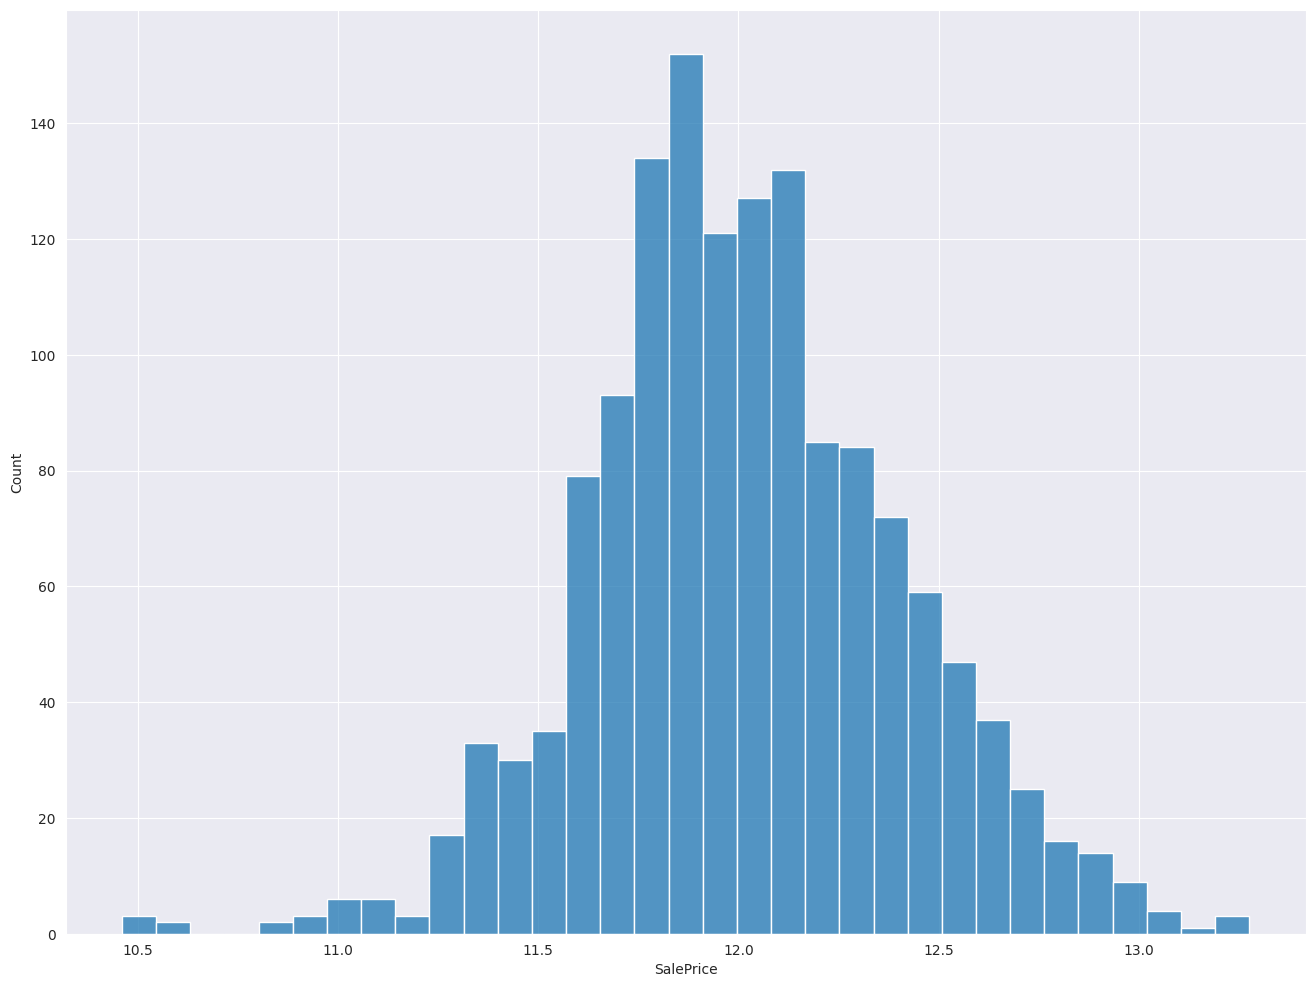

In [169]:
# Generating a heatmap
correlation_matrix = train_dff.corr(numeric_only=True)
plt.figure(figsize = (16,12))
# sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")

# Drop any higher value from the heatmap(garage are/ garagecars)
# train_dff = train_dff.drop(columns=["GarageArea"])
# test_df = test_df.drop(columns=["GarageArea"])

# Now we can apply logarithm to values for better prediction
# sns.histplot(
#     train_dff,
#     x = train_dff["SalePrice"]
# )
train_dff["SalePrice"] = np.log1p(train_dff["SalePrice"])
sns.histplot(
    train_dff,
    x = train_dff["SalePrice"]
)

In [170]:
# Build the pipeline
# print(train_dff.dtypes[train_dff.dtypes=="object"])

# Encoding the data
ode_cols = ["LotShape", "LandContour", "Utilities", "LandSlope", "BsmtQual", "BsmtFinType1", "CentralAir", "Functional", "FireplaceQu", "GarageFinish", "GarageQual", "PavedDrive", "ExterCond", "OverallQual"]

ohe_cols = ["Street", "LotConfig", "Condition1", "Condition2", "BldgType", "MasVnrType", "Foundation", "Electrical", "SaleType", "MSZoning", "SaleCondition", "Exterior1st", "Exterior2nd", "HeatingQC", "GarageType"]

num_cols = train_dff.select_dtypes(include=["int", "float"]).columns
# num_cols
num_cols = num_cols.drop("SalePrice")


In [171]:
num_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

ode_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
ohe_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
col_trans = ColumnTransformer(transformers=[
    ("num_p", num_pipeline, num_cols),
    ("ode_p", ode_pipeline, ode_cols),
    ("ohe_p", ohe_pipeline, ohe_cols),
    ],
    remainder="passthrough",
    n_jobs = -1)

In [172]:
# Pipiline building done
pipeline = Pipeline(steps=[
    ("preprocessing", col_trans)
])


In [173]:
# Data fitting
X = train_dff.drop("SalePrice", axis = 1)
y = train_dff["SalePrice"]

X_preprocessed = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size = .2, random_state = 25)

In [162]:
# Building Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mean_squared_error(y_test, y_pred_lr)

ValueError: could not convert string to float: 'Gilbert'

In [111]:
 # Outliers using query for MSSubClass 4
# 692,  899, 1170, 1183

# Outliers using query for LotFrontage 4
# 692, 899, 1170, 1183, 935, 1299


# Outliers using query for LotArea 4
# 692, 899, 1170, 1183, 314, 336, 250, 707, 452, 1299



# Outliers using query for OverallQual 4
# 692, 899, 1170, 1183


# Outliers using query for MasVnrArea 4
# 692, 899, 1170, 1183


# Outliers using query for BsmtFinSF1 4
# 692, 899, 1170, 1183, 1299
# Outliers using mean/median BsmtFinSF1 1
# 1299


# Outliers using query for BsmtUnfSF 4
# 692, 899, 1170, 1183


# Outliers using query for TotalBsmtSF 4
# 692, 899, 1170, 1183
# Outliers using mean/median TotalBsmtSF 1
# 1299


# Outliers using query for 1stFlrSF 4
# 692, 899, 1170, 1183
# Outliers using mean/median 1stFlrSF 1
# 1299


# Outliers using query for 2ndFlrSF 4
# 692, 899, 1170, 1183


# Outliers using query for GarageCars 4
# 692, 899, 1170, 1183


# Outliers using query for GarageArea 2
# 692, 1183
# Outliers using mean/median GarageArea 4
# 582, 1062, 1191, 1299


# Outliers using query for WoodDeckSF 2
# 692, 1183
# Outliers using mean/median WoodDeckSF 1
# 54


# Outliers using query for OpenPorchSF 2
# 692, 1183
# Outliers using mean/median OpenPorchSF 3
# 496, 584, 1329


# Outliers using query for PoolArea 2
# 692, 1183
# Outliers using mean/median PoolArea 7
# 198, 811, 1171, 1183, 1299, 1387, 1424
# Sale price zscore with train_df raw PoolArea 10
# 1299, 198, 1387, 1183, 1171, 811, 1424

In [ ]:
# Handling Missing values
# 2.1 Drop missing values

# 2.2 Impute


# 2.3 Extension to impute

In [ ]:
# print(train_df.columns)
# print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))

ids = [692, 899, 1170, 1183,  441, 804,  1047, 1299, 250, 314, 336, 452, 707, 770, 497]


# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]
train_df_filtered = train_df[~train_df['Id'].isin(new_df['Id'])]


train_df_filtered.drop(columns=["BsmtExposure"], inplace=True)
# train_df_filtered.loc[:, "GarageType"] = train_df_filtered["GarageType"].fillna("Attchd")
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))


In [ ]:
train_df_filtered.drop(columns=["GarageFinish"], inplace=True)
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))


In [ ]:
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).head(20))

train_df_filtered


In [ ]:
mean
std
min
25
50
75
max

In [ ]:
# Price
Outliers using query


[250, 314, 336, 452, 707, 1299]
Outliers using mean/median
[179, 441, 692, 770, 799, 804, 899, 1047, 1170, 1183]

Outliers using query for MSSubClass 7
[441, 692, 804, 899, 1047, 1170, 1183]

Outliers using query for LotFrontage 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median LotFrontage 5
[198, 232, 935, 1128, 1299]

Outliers using query for LotArea 7
[441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median LotArea 13
# [54, 250, 314, 336, 385, 452, 458, 662, 707, 770, 849, 1299, 1397]

Outliers using query for OverallQual 7
# [441, 692, 804, 899, 1047, 1170, 1183]

Outliers using query for BsmtUnfSF 7
# [441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median BsmtUnfSF 4
# [225, 279, 478, 679]

Outliers using query for 1stFlrSF 7
# [441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median 1stFlrSF 5
# [497, 524, 1025, 1299, 1374]

Outliers using query for 1stFlrSF 7
# [441, 692, 804, 899, 1047, 1170, 1183]
Outliers using mean/median 1stFlrSF 3
# [497, 524, 1299]

Outliers using query for 2ndFlrSF 4
[692, 899, 1170, 1183]


In [ ]:
ids = [692, 899, 1170, 1183,  441, 804,  1047, 1299, 250, 314, 336, 452, 707, 770, 497]

# Filter the rows based on the IDs
new_df = train_df.loc[train_df['Id'].isin(ids)]

# Display the new DataFrame
new_df

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(x="SalePrice", y="LotArea", data=train_df, label="train", ax=axes[0])
sns.scatterplot(x="SalePrice", y="LotArea", data=new_df, label="q", ax=axes[0])


# KDE plots
sns.kdeplot(x="SalePrice", y="LotArea", data=train_df, color='blue', ax=axes[1])
sns.kdeplot(x="SalePrice", y="LotArea", data=new_df, color="orange", ax=axes[1])


# Set titles for subplots
axes[0].set_title('Scatter Plot')
axes[1].set_title('KDE Plot')

# Show plots
plt.show()
new_df.columns

In [ ]:

from collections import Counter

a = [250, 314, 336, 452, 707, 1299, 179, 441, 692, 770, 799, 804, 899, 1047, 1170, 1183, 441, 692, 804, 899, 1047, 1170, 1183, 198, 232, 935, 1128, 1299, 441, 692, 804, 899, 1047, 1170, 1183, 54, 250, 314, 336, 385, 452, 458, 662, 707, 770, 849, 1299, 1397, 441, 692, 804, 899, 1047, 1170, 1183, 441, 692, 804, 899, 1047, 1170, 1183, 225, 279, 478, 679, 441, 692, 804, 899, 1047, 1170, 1183, 497, 524, 1025, 1299, 1374, 441, 692, 804, 899, 1047, 1170, 1183, 497, 524, 1299, 692, 899, 1170, 1183]

counts = Counter(a)
ll = []
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

sorted_dict = dict(sorted_counts)

# print(sorted_dict)
for key, value in sorted_dict.items():
    # if value >= 2:
    #     ll.append(key)
    print(key, value)
    
    # 
ll

In [ ]:
corr(train_df["SalePrice"].